In [1]:
import numpy
import pylab

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE

from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library.standard_gates import XGate
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter

from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler, Session, Estimator

In [2]:
import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning

old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass

In [3]:
# Your token can be found here: https://quantum-computing.ibm.com/
API_TOKEN = "?"

In [4]:
# Save account credentials locally in $HOME/.qiskit/qiskit-ibm.json (you'll need to run this only once!). 
#IBMProvider.save_account(token=API_TOKEN, overwrite=True)

In [5]:
# Load a previously saved account and optionally select a 
# different hub/group/project in case you have access
with no_ssl_verification():
    provider = IBMProvider(instance="ibm-q/open/main")

In [6]:
# Select quantum device to run on. Select simulator -> True if you want to run on a simulator which is faster
# INSPECT DEVICES YOU HAVE ACCESS TO HERE: https://quantum-computing.ibm.com/services/resources?tab=yours
with no_ssl_verification():
    backends = provider.backends(filters=lambda x: x.configuration().n_qubits >= (2) \
        and (x.configuration().simulator == True) and (x.status().operational))
    backend = least_busy(backends)
    print("Selected the least busy backend: ", backend.name)

Selected the least busy backend:  simulator_statevector


In [7]:
# If using a simulator it is recommended to use ibmq_qasm_simulator 
# since it works like a real quantum device, other simulators are different
with no_ssl_verification():
    backend = provider.get_backend("ibmq_qasm_simulator")

In [9]:
# Qiskit Runtime: is a programming model and containerized environment for deploying quantum programs, designed to reduce the 
# computational cycle time between quantum and classical computers. For details please checkout following resources
# https://medium.com/qiskit/so-what-is-qiskit-runtime-anyway-c78aecf3742
# https://qiskit.org/ecosystem/ibm-runtime/
with no_ssl_verification():
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.backend(backend.name)

In [10]:
# The solver is the algorithm through which the ground state is computed. 
# This solver in particular computes the molecule ground state classically
npmes = NumPyMinimumEigensolver()

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

classical_result = npmes.compute_minimum_eigenvalue(operator=H2_op)
print("The ground state electronic energy computed classically is: ", classical_result.eigenvalue)

The ground state electronic energy computed classically is:  -1.857275030202379


In [11]:
# initializing an instance of qiskit_ibm_runtime.Sampler rather than 
# qiskit.primitives.Sampler to use Qiskit Runtime’s implementation of the Sampler
options = Options(environment={"log_level": "INFO"})
# optimization_level=3 adds dynamical decoupling
options.optimization_level=3
# resilience_level=1 adds readout error mitigation
options.resilience_level=0
options.execution.shots = 10000

In [12]:
counts = []
values = []

def print_and_store_intermediate_result(eval_count, parameters, mean, std):
    print("Eval count: ", eval_count, "Mean value: ", mean)
    counts.append(eval_count)
    values.append(mean)

with no_ssl_verification():
    with Session(service=service, backend=backend, max_time="10s") as session:
        # Qiskit runtimes uses one of two primitives a Sampler for sampling probabilities distributions or an Estimator
        estimator = Estimator(options=options)
        # the classical optimizer algorithm (other options exist here)
        optimizer = COBYLA(maxiter=100)
        # the ansatz is a just a guess for the wavefunction of the molecule whose parameters
        # will be optimized by VQE class in order to find the valye of the ground state energy
        ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
        
        vqe = VQE(estimator, ansatz, optimizer, callback=print_and_store_intermediate_result)
        result = vqe.compute_minimum_eigenvalue(operator=H2_op)

Eval count:  1 Mean value:  -1.235710042548606
Eval count:  2 Mean value:  -1.3749690131030547
Eval count:  3 Mean value:  -1.2240279076957983
Eval count:  4 Mean value:  -1.1205253793347192
Eval count:  5 Mean value:  -1.3563391450586304
Eval count:  6 Mean value:  -1.5987971159238294
Eval count:  7 Mean value:  -1.5075087020372886
Eval count:  8 Mean value:  -1.7985504589939714
Eval count:  9 Mean value:  -1.5644521847784756
Eval count:  10 Mean value:  -1.3400867835070422
Eval count:  11 Mean value:  -1.8274467462272055
Eval count:  12 Mean value:  -1.82813315767946
Eval count:  13 Mean value:  -1.7358127877531655
Eval count:  14 Mean value:  -1.7846693803091824
Eval count:  15 Mean value:  -1.7360283557129257
Eval count:  16 Mean value:  -1.8003231095992234
Eval count:  17 Mean value:  -1.8120836619533451
Eval count:  18 Mean value:  -1.841580129023272
Eval count:  19 Mean value:  -1.8056337090815753
Eval count:  20 Mean value:  -1.8470885598654352
Eval count:  21 Mean value:  -1.7

In [13]:
print("The ground state electronic energy obtained using a quantum algorithm is: ", result.eigenvalue)

The ground state electronic energy obtained using a quantum algorithm is:  -1.8529649617461001


Text(0.5, 1.0, 'Convergence of VQE for the H2 molecule')

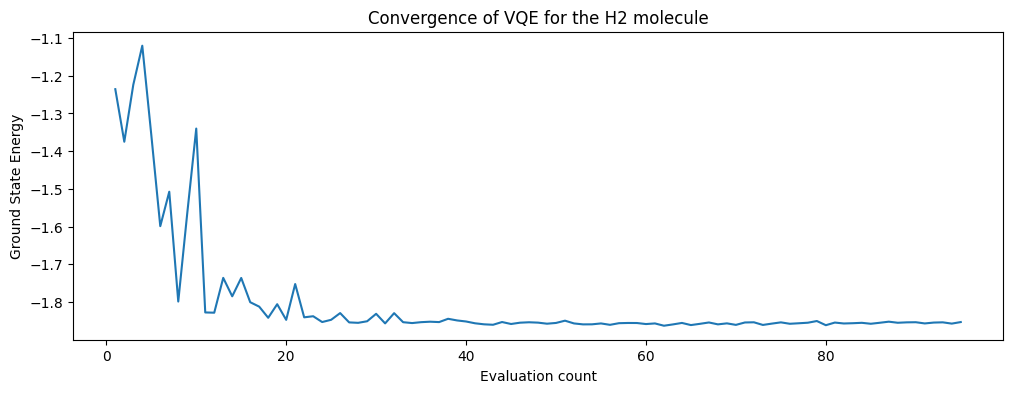

In [14]:
pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Evaluation count")
pylab.ylabel("Ground State Energy")
pylab.title("Convergence of VQE for the H2 molecule")

In [16]:
from qiskit.tools.jupyter import *

%qiskit_version_table